The pre processor is used to process all data into a suitable format for the autoencoder.

In [32]:
# PREPROCESSOR 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Loading Data from CSV
your_path = r'C:\Users\gusta\Documents\KTH\TriOptima\trioptima'
file_path = your_path + '/RT.IRS_CLEAN.csv'
data = pd.read_csv(file_path)

# Handling DateTime Variables
data['effectiveDate'] = pd.to_datetime(data['effectiveDate'], errors='coerce')
data['effectiveYear'] = data['effectiveDate'].dt.year
data['effectiveMonth'] = data['effectiveDate'].dt.month
data['effectiveDay'] = data['effectiveDate'].dt.day

# Drop the original 'effectiveDate' column
data = data.drop(columns=['effectiveDate'])

# Identifying variable types
numerical_vars = ['leg1FixedRate', 'leg1FixedRatePaymentFrequencyMultiplier', 'effectiveYear', 'effectiveMonth', 'effectiveDay']
categorical_vars = ['action', 'assetClass', 'leg2UnderlierTenorPeriod', 'leg2ResetFrequencyPeriod']

# Preprocessing: Numerical Variables
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing: Categorical Variables
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column Transformer: Applying transformations to respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_vars),
        ('cat', categorical_transformer, categorical_vars)
    ]
)

# Applying Preprocessing
data_preprocessed = pd.DataFrame(preprocessor.fit_transform(data))


Exporting the processed data into a .csv

In [13]:
import os

# Define the path
path = your_path

# Check if the path does not exist
if not os.path.exists(path):
    # Create the directory
    os.makedirs(path)

# Now you can save the DataFrame
data_preprocessed.to_csv(f'{path}/processed_data.csv', index=False)



Defining the autoencoder module

In [21]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras import backend as K

# Load preprocessed data
file_path = your_path + '/processed_data.csv'  # Please replace 'your_path' with actual path
data_preprocessed = pd.read_csv(file_path, header=0)

# Check to make sure the data is in expected format
assert data_preprocessed.applymap(np.isreal).all().all(), "Non-numeric data found"
assert not data_preprocessed.isnull().any().any(), "NaN values found"

# Dimensions
input_dim = data_preprocessed.shape[1]
encoding_dim = int(input_dim / 2)

# Set layer and neurons options
layer_options = [1, 10, 40]
neuron_options = [1, 10, 40, 100, 200]

# Variables to store the best model's configurations and weights
best_val_loss = float('inf')  # Set initial value to infinity
best_num_layers = None
best_num_neurons = None
best_weights = None

# Iterate over neuron configurations
for num_neurons in neuron_options:
    # Iterate over layer configurations
    for num_layers in layer_options:
        K.clear_session()

        input_layer = layers.Input(shape=(input_dim,))
        encoder_layer = layers.Dense(num_neurons, activation='relu')(input_layer)
        
        # Add extra layers based on num_layers
        for _ in range(1, num_layers):
            encoder_layer = layers.Dense(num_neurons, activation='relu')(encoder_layer)

        decoder_layer = layers.Dense(input_dim, activation='sigmoid')(encoder_layer)

        temp_autoencoder = models.Model(inputs=input_layer, outputs=decoder_layer)
        temp_autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        
        history = temp_autoencoder.fit(
            data_preprocessed, data_preprocessed,
            epochs=10,  # Adjust this as needed
            batch_size=32,
            shuffle=True,
            validation_split=0.1
        )
        
        final_val_loss = history.history['val_loss'][-1]
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_num_layers = num_layers
            best_num_neurons = num_neurons
            best_weights = temp_autoencoder.get_weights()

# Construct the best model with configurations
K.clear_session()
input_layer = layers.Input(shape=(input_dim,))
encoder_layer = layers.Dense(best_num_neurons, activation='relu')(input_layer)
for _ in range(1, best_num_layers):
    encoder_layer = layers.Dense(best_num_neurons, activation='relu')(encoder_layer)
decoder_layer = layers.Dense(input_dim, activation='sigmoid')(encoder_layer)

autoencoder = models.Model(inputs=input_layer, outputs=decoder_layer)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Load the best weights into the best model
autoencoder.set_weights(best_weights)

# Display the number of layers and neurons in the best model
print(f"Best Model Configuration:\nNumber of Layers: {best_num_layers}\nNumber of Neurons per Layer: {best_num_neurons}")


Epoch 1/10


C:\Users\gusta\AppData\Local\Temp\ipykernel_2856\4222863518.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  assert data_preprocessed.applymap(np.isreal).all().all(), "Non-numeric data found"


164/164 [==============================] - 1s 2ms/step - loss: 0.5691 - val_loss: 0.5367
Epoch 2/10
164/164 [==============================] - 0s 1ms/step - loss: 0.5356 - val_loss: 0.5037
Epoch 3/10
164/164 [==============================] - 0s 1ms/step - loss: 0.5020 - val_loss: 0.4665
Epoch 4/10
164/164 [==============================] - 0s 1ms/step - loss: 0.4691 - val_loss: 0.4381
Epoch 5/10
164/164 [==============================] - 0s 1ms/step - loss: 0.4437 - val_loss: 0.4216
Epoch 6/10
164/164 [==============================] - 0s 1ms/step - loss: 0.4257 - val_loss: 0.4123
Epoch 7/10
164/164 [==============================] - 1s 4ms/step - loss: 0.4128 - val_loss: 0.4065
Epoch 8/10
164/164 [==============================] - 1s 5ms/step - loss: 0.4033 - val_loss: 0.4022
Epoch 9/10
164/164 [==============================] - 1s 3ms/step - loss: 0.3961 - val_loss: 0.3988
Epoch 10/10
164/164 [==============================] - 1s 3ms/step - loss: 0.3904 - val_loss: 0.3960
Epoch 1/10

Training the autoencoder

In [22]:
history = autoencoder.fit(
    data_preprocessed, data_preprocessed,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.1  # 10% of data for validation
)


Epoch 1/100
164/164 [==============================] - 1s 2ms/step - loss: 0.2015 - val_loss: 0.1960
Epoch 2/100
164/164 [==============================] - 0s 2ms/step - loss: 0.2013 - val_loss: 0.1957
Epoch 3/100
164/164 [==============================] - 0s 2ms/step - loss: 0.2013 - val_loss: 0.1955
Epoch 4/100
164/164 [==============================] - 0s 1ms/step - loss: 0.2012 - val_loss: 0.1954
Epoch 5/100
164/164 [==============================] - 0s 1ms/step - loss: 0.2012 - val_loss: 0.1954
Epoch 6/100
164/164 [==============================] - 0s 1ms/step - loss: 0.2012 - val_loss: 0.1953
Epoch 7/100
164/164 [==============================] - 0s 1ms/step - loss: 0.2011 - val_loss: 0.1953
Epoch 8/100
164/164 [==============================] - 0s 1ms/step - loss: 0.2011 - val_loss: 0.1953
Epoch 9/100
164/164 [==============================] - 0s 1ms/step - loss: 0.2011 - val_loss: 0.1952
Epoch 10/100
164/164 [==============================] - 0s 1ms/step - loss: 0.2011 - val_lo

Anomaly detection

In [24]:
# Obtain the reconstructed data
predictions = autoencoder.predict(data_preprocessed)

# Measure the reconstruction error
mse = np.mean(np.power(data_preprocessed - predictions, 2), axis=1)

# Convert mse to a DataFrame for easier handling
mse_df = pd.DataFrame({'reconstruction_error': mse})

# Display basic statistics of the error
print(mse_df.describe())


182/182 [==============================] - 0s 881us/step
       reconstruction_error
count           5804.000000
mean               0.200307
std                0.374389
min                0.000081
25%                0.033074
50%                0.094842
75%                0.210015
max                3.809738


Visualize

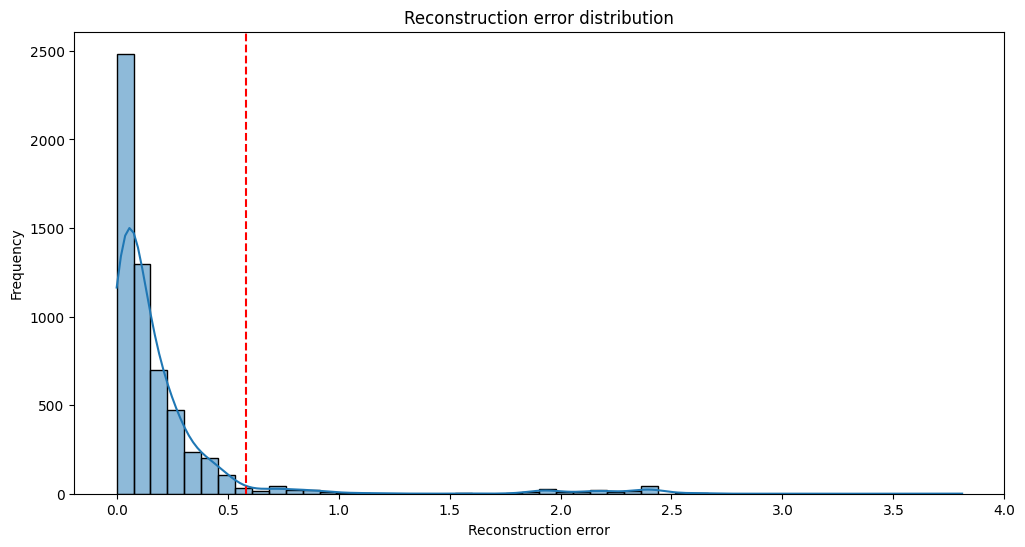

Anomaly threshold: 0.5831222213097864


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(mse_df['reconstruction_error'], bins=50, kde=True)
plt.title('Reconstruction error distribution')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')


threshold = np.percentile(mse_df['reconstruction_error'], 95)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.show() 
print(f"Anomaly threshold: {threshold}")



Test new data for outliers

In [33]:
import pandas as pd
import numpy as np

# Load new trade data from CSV
new_data_path = your_path + '/New_Trades_IRS.csv'  
new_data = pd.read_csv(new_data_path)

# ... (Repeat the preprocessing steps for the new data as you've done for training data)

# Preprocessing for example
new_data['effectiveDate'] = pd.to_datetime(new_data['effectiveDate'], errors='coerce')
new_data['effectiveYear'] = new_data['effectiveDate'].dt.year
new_data['effectiveMonth'] = new_data['effectiveDate'].dt.month
new_data['effectiveDay'] = new_data['effectiveDate'].dt.day
new_data = new_data.drop(columns=['effectiveDate'])

# Apply the preprocessing transformers
new_data_preprocessed = pd.DataFrame(preprocessor.transform(new_data))

# Predict with the autoencoder (make sure the autoencoder variable is already defined and trained)
new_predictions = autoencoder.predict(new_data_preprocessed)

# Measure the reconstruction error
new_mse = np.mean(np.power(new_data_preprocessed - new_predictions, 2), axis=1)
new_mse_df = pd.DataFrame({'reconstruction_error': new_mse})

# Set a threshold for anomaly detection
threshold = mse_df['reconstruction_error'].quantile(0.99)  # adjust this based on your trained data analysis

# Determine whether each trade is an outlier or not
new_mse_df['outlier'] = new_mse_df['reconstruction_error'] > threshold

# Add 'outlier' information back to the original new_data DataFrame
new_data.reset_index(drop=True, inplace=True)  # Resetting index to ensure concatenation alignment
new_data['outlier'] = new_mse_df['outlier'].values

# Filter the outlier trades
outlier_trades = new_data[new_data['outlier'] == True]

# Save the outlier trades to a CSV file
outlier_file_path = your_path + '/Outlier_Trades_IRS.csv'  
outlier_trades.to_csv(outlier_file_path, index=False)


1/1 [==============================] - 0s 14ms/step
